In [1]:
import os
import tensorflow as tf

#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [2]:
from keras.models import load_model

model_path = r'D:\git\kaggle\dogs-vs-cats-small\cats_and_dogs_small_2.h5'
model = load_model(model_path)
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 34, 34, 128)       73856     
_______________________________________

In [3]:
img_path = r'D:\git\kaggle\dogs-vs-cats-small\test\cats\cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255

print(img_tensor.shape)

(1, 150, 150, 3)


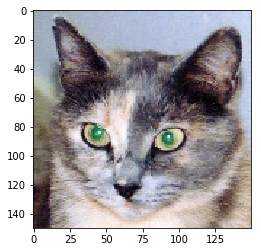

In [5]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [6]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [7]:
activations = activation_model.predict(img_tensor)

for activation in activations:
    print(activation.shape)

(1, 148, 148, 32)
(1, 74, 74, 32)
(1, 72, 72, 64)
(1, 36, 36, 64)
(1, 34, 34, 128)
(1, 17, 17, 128)
(1, 15, 15, 128)
(1, 7, 7, 128)


(1, 148, 148, 32)


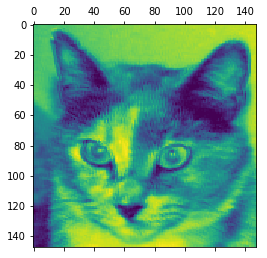

In [8]:
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')
print(first_layer_activation.shape)

(1, 148, 148, 32)


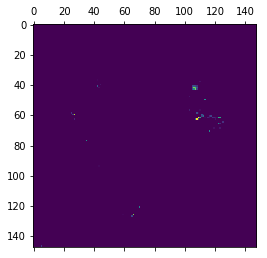

In [9]:
plt.matshow(first_layer_activation[0, :, :, 30], cmap='viridis')
print(first_layer_activation.shape)

C:\Users\suizh\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


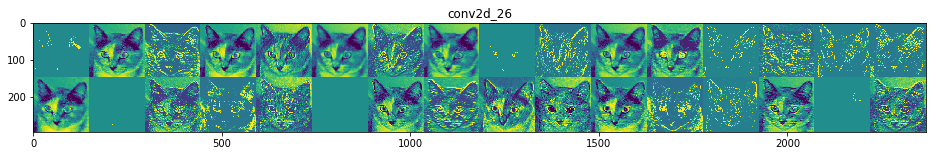

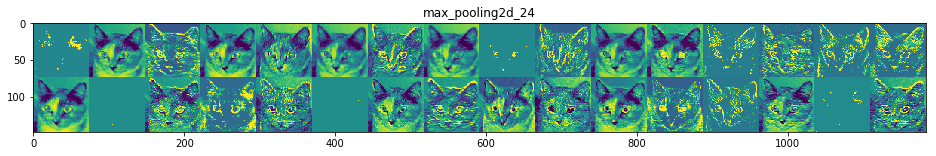

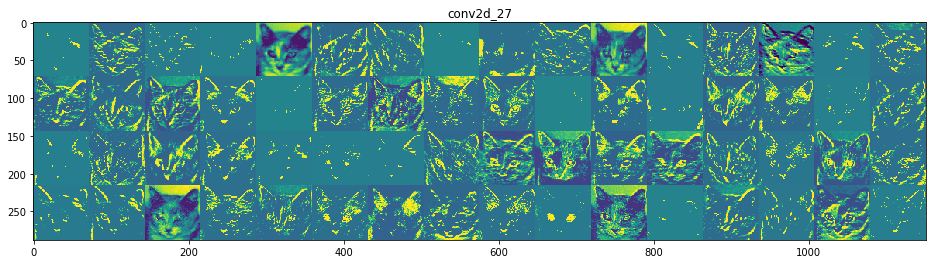

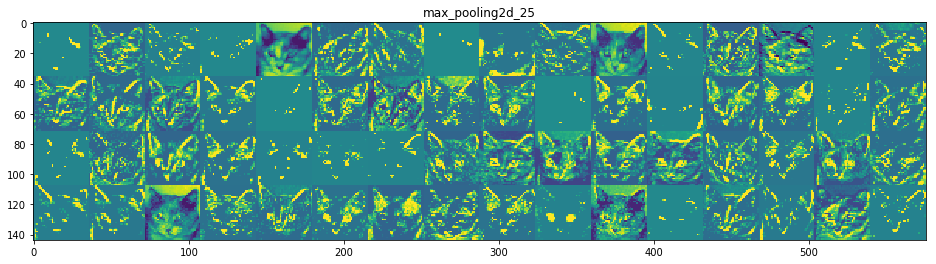

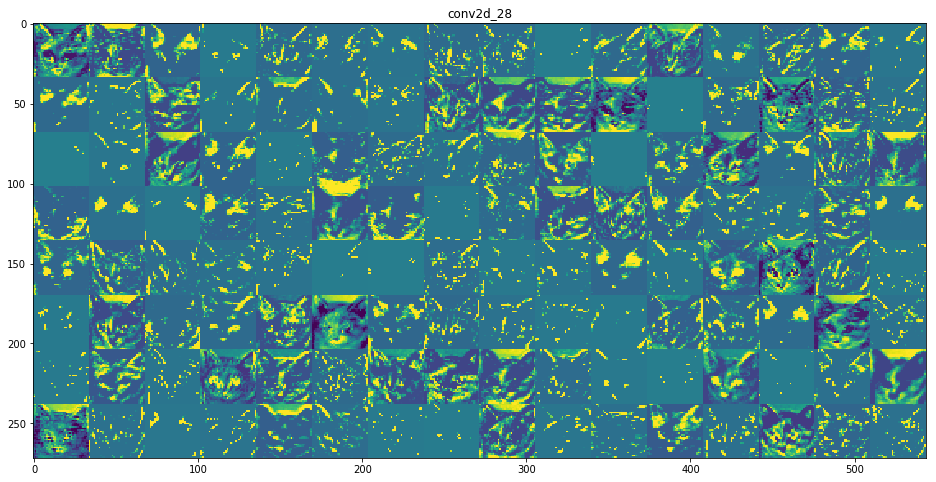

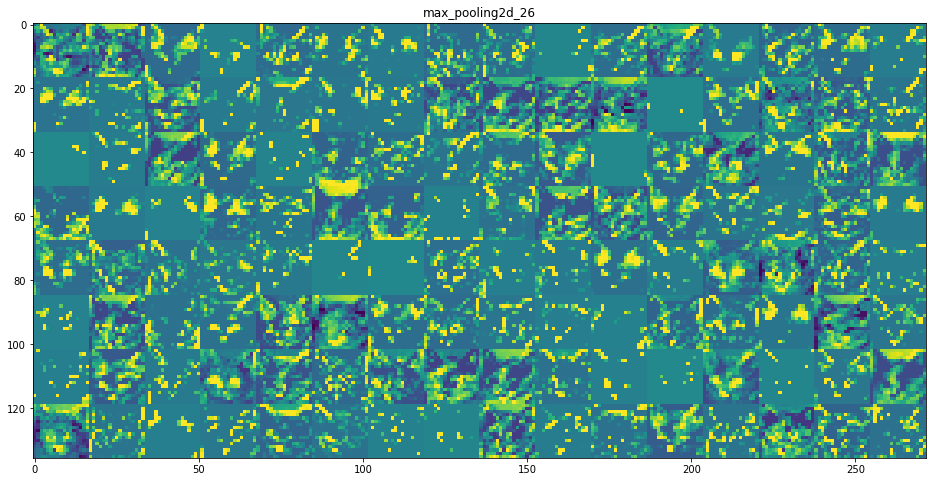

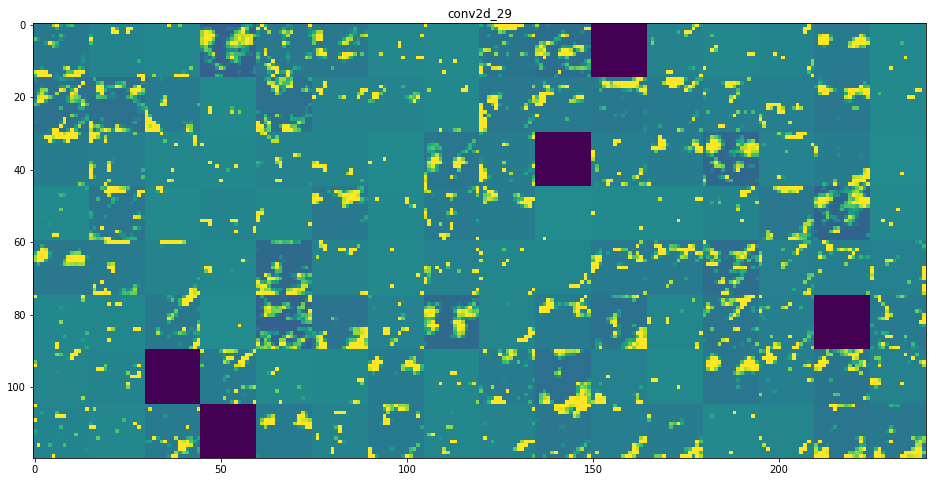

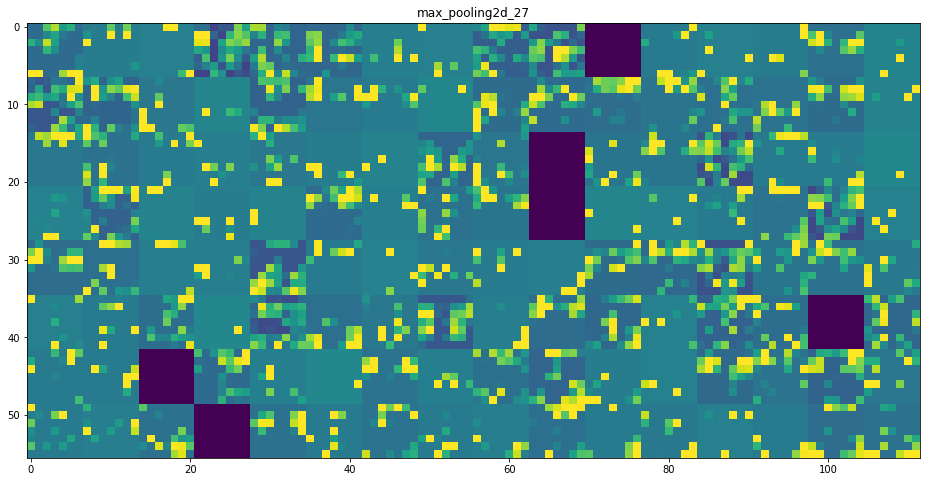

In [10]:
import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

In [11]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [12]:
grads = K.gradients(loss, model.input)[0]

In [13]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [14]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [15]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

In [16]:
step = 1
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [17]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [18]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    step = 1
    for i in range (40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

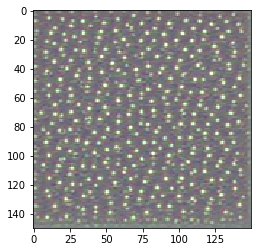

In [21]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


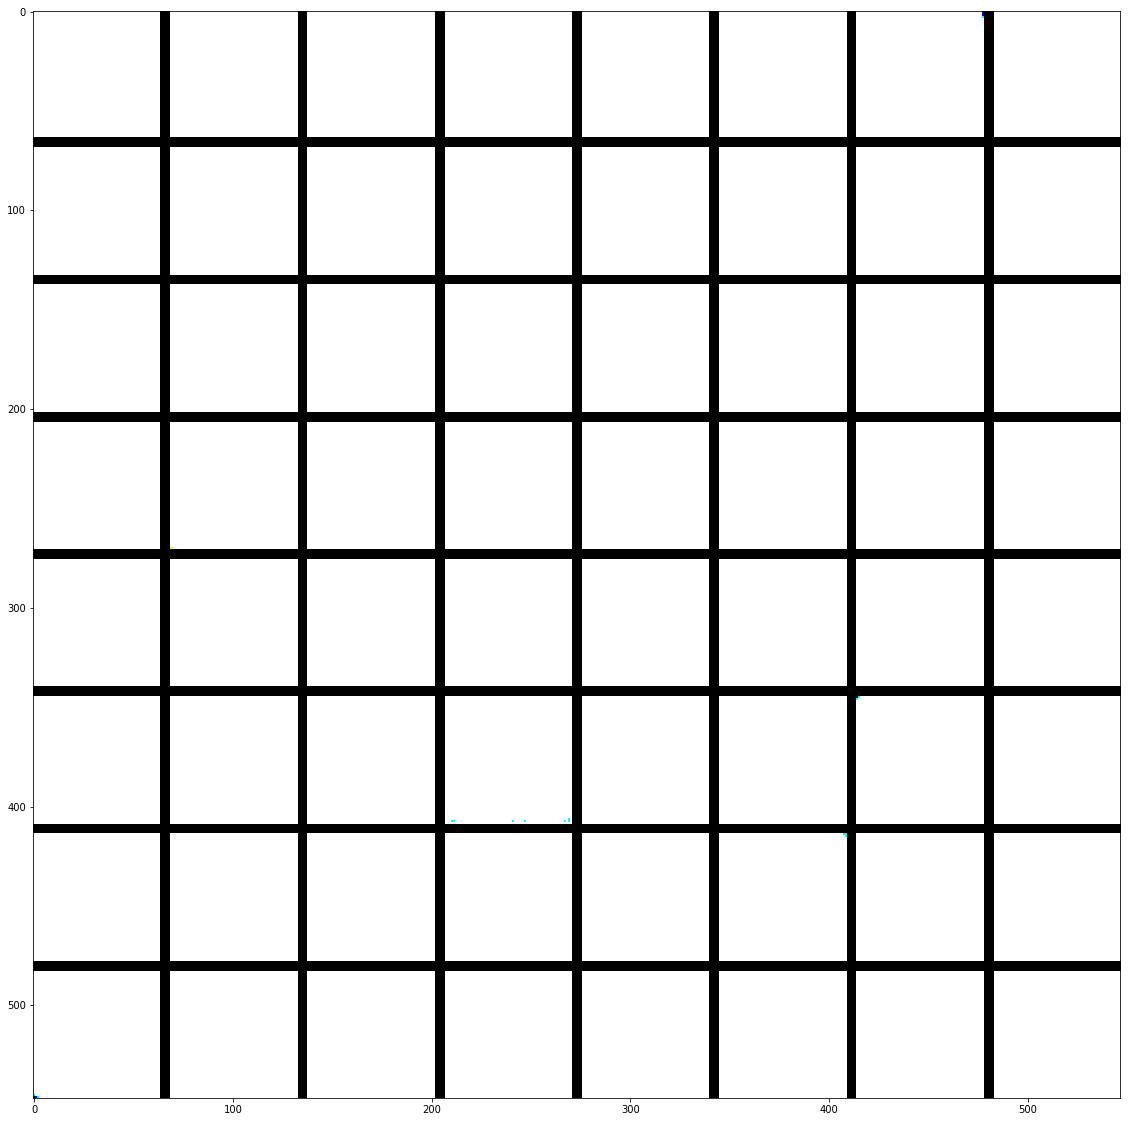

In [24]:
for layer_name in ['block1_conv1']: #, 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [25]:
from keras.applications.vgg16 import VGG16

K.clear_session()

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 53s 0us/step


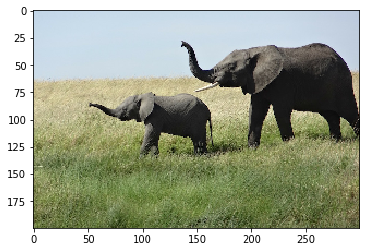

In [37]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

download_path = r'C:\Users\suizh\Downloads\creative_commons_elephant.jpg'

img = image.load_img(download_path, target_size=(200, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255
plt.imshow(img_tensor[0])
plt.show()

img = image.load_img(download_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [38]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258), ('n02504013', 'Indian_elephant', 0.004354576)]


In [39]:
np.argmax(preds[0])

386

In [40]:
african_elephant_output = model.output[:, 386]
last_conv_layer = model.get_layer('block5_conv3')
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

heatmap = np.mean(conv_layer_output_value, axis=-1)

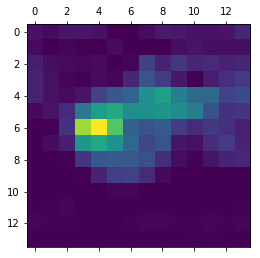

In [41]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [42]:
import cv2

img = cv2.imread(img_path)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
save_path = r'C:\Users\suizh\Downloads\elephant_cam.jpg'
cv2.imwrite(save_path, superimposed_img)

True

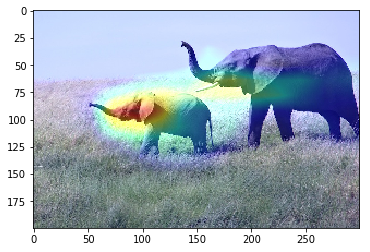

In [43]:
img = image.load_img(save_path, target_size=(200, 300))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255
plt.imshow(img_tensor[0])
plt.show()